<a href="https://colab.research.google.com/github/Bhumi-2/ds_bhumika_khatwani/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primetrade.ai - Data Science Assignment

This notebook loads the Bitcoin Fear & Greed Index and Hyperliquid historical trader data, engineers features, merges them, and generates CSVs and plots as required by the assignment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

plt.style.use("default")
sns.set(rc={"figure.figsize": (10, 5)})

os.makedirs("csv_files", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


## Load Raw Datasets
Upload `fear_greed_index.csv` and `historical_data.csv` in the Colab file browser, then run the cell below.

In [2]:
fear = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

display(fear.head())
display(trades.head())
print("Fear/Greed columns:", fear.columns.tolist())
print("Trades columns:", trades.columns.tolist())


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12


Fear/Greed columns: ['timestamp', 'value', 'classification', 'date']
Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


## Clean & Prepare Fear / Greed Index

In [3]:
if "date" in fear.columns:
    fear["date"] = pd.to_datetime(fear["date"])
else:
    if "timestamp" in fear.columns:
        fear["date"] = pd.to_datetime(fear["timestamp"], unit="s")
    else:
        raise ValueError("No usable date column found in fear_greed_index.csv")

rename_map = {}
if "value" in fear.columns:
    rename_map["value"] = "fg_value"
if "classification" in fear.columns:
    rename_map["classification"] = "fg_class"

fear = fear.rename(columns=rename_map)

print("Fear/Greed date range:", fear["date"].min(), "->", fear["date"].max())
print("Sentiment classes:")
print(fear.get("fg_class", pd.Series(dtype=str)).value_counts())

fear.to_csv("csv_files/fear_greed_cleaned.csv", index=False)


Fear/Greed date range: 2018-02-01 00:00:00 -> 2025-05-02 00:00:00
Sentiment classes:
fg_class
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


## Clean & Prepare Hyperliquid Trader Data

In [4]:
numeric_candidates = [
    "Execution Price", "Size Tokens", "Size USD",
    "Closed PnL", "Fee", "Timestamp"
]
for col in numeric_candidates:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors="coerce")

if "Timestamp" in trades.columns:
    trades["ts"] = pd.to_datetime(trades["Timestamp"], unit="ms", utc=True).dt.tz_convert("Asia/Kolkata")
else:
    ts_col = None
    for c in trades.columns:
        if "time" in c.lower():
            ts_col = c
            break
    if ts_col is None:
        raise ValueError("No timestamp column found in trades data.")
    trades["ts"] = pd.to_datetime(trades[ts_col])

trades["date"] = trades["ts"].dt.floor("D")

print("Trader date range:", trades["date"].min(), "->", trades["date"].max())
trades.head()


Trader date range: 2024-03-09 00:00:00+05:30 -> 2025-06-15 00:00:00+05:30


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,ts,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12,2024-10-27 09:03:20+05:30,2024-10-27 00:00:00+05:30
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12,2024-10-27 09:03:20+05:30,2024-10-27 00:00:00+05:30
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12,2024-10-27 09:03:20+05:30,2024-10-27 00:00:00+05:30
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12,2024-10-27 09:03:20+05:30,2024-10-27 00:00:00+05:30
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12,2024-10-27 09:03:20+05:30,2024-10-27 00:00:00+05:30


## Feature Engineering – Per Trade Metrics

In [5]:
if "Side" in trades.columns:
    trades["side_sign"] = trades["Side"].map({"BUY": 1, "SELL": -1})
else:
    trades["side_sign"] = 1

if "Size USD" in trades.columns:
    trades["gross_volume_usd"] = trades["Size USD"].abs()
else:
    if "Size Tokens" in trades.columns and "Execution Price" in trades.columns:
        trades["gross_volume_usd"] = (trades["Size Tokens"] * trades["Execution Price"]).abs()
    else:
        trades["gross_volume_usd"] = np.nan

trades["signed_volume_usd"] = trades["gross_volume_usd"] * trades["side_sign"]

if "Closed PnL" in trades.columns:
    trades["profit"] = trades["Closed PnL"].clip(lower=0)
    trades["loss"] = -trades["Closed PnL"].clip(upper=0)
else:
    trades["profit"] = 0.0
    trades["loss"] = 0.0

trades[["gross_volume_usd", "signed_volume_usd"]].head()


,gross_volume_usd,signed_volume_usd
0,7872.16,7872.16
1,127.68,127.68
2,1150.63,1150.63
3,1142.04,1142.04
4,69.75,69.75


## Aggregate to Daily Level

In [6]:
daily = trades.groupby("date").agg(
    trades_count=("gross_volume_usd", "count"),
    accounts_n=("Account", "nunique") if "Account" in trades.columns else ("gross_volume_usd", "count"),
    gross_volume_usd=("gross_volume_usd", "sum"),
    net_volume_usd=("signed_volume_usd", "sum"),
    total_profit=("profit", "sum"),
    total_loss=("loss", "sum"),
    avg_trade_size_usd=("gross_volume_usd", "mean"),
    median_trade_size_usd=("gross_volume_usd", "median"),
    mean_pnl_per_trade=("Closed PnL", "mean") if "Closed PnL" in trades.columns else ("profit", "mean")
).reset_index()

daily.head()


,date,trades_count,accounts_n,gross_volume_usd,net_volume_usd,total_profit,total_loss,avg_trade_size_usd,median_trade_size_usd,mean_pnl_per_trade
0,2024-03-09 00:00:00+05:30,818,2,4.640448e+06,-27071.84,2.942860e+04,37348.072899,5672.919829,1997.930,-9.681505
1,2024-07-03 00:00:00+05:30,1558,2,1.377735e+07,-125804.89,2.330628e+05,113490.900940,8842.974705,3995.670,76.747074
2,2024-10-27 00:00:00+05:30,3094,7,4.297549e+07,-499310.35,3.546388e+05,337788.887171,13889.945368,4000.715,5.446001
3,2025-02-20 00:00:00+05:30,15721,7,2.967750e+08,7014065.87,3.271934e+06,296146.449793,18877.617913,1987.550,189.287392
4,2025-06-15 00:00:00+05:30,6740,5,2.577739e+08,-8635539.52,5.683854e+05,82975.871302,38245.380540,4182.470,72.019217


In [7]:
# Save daily trades summary
daily.to_csv("csv_files/trades_cleaned.csv", index=False)
print("Saved daily trades summary to csv_files/trades_cleaned.csv")


Saved daily trades summary to csv_files/trades_cleaned.csv


## Merge Daily Trades with Sentiment

In [8]:
fear["date"] = pd.to_datetime(fear["date"])
fear["date"] = fear["date"].dt.tz_localize(None)

daily["date"] = daily["date"].dt.tz_localize(None)

merged = daily.merge(
    fear[["date", "fg_value", "fg_class"]],
    on="date",
    how="left"
)

merged["profit_margin"] = merged["total_profit"] / (
    merged["total_profit"] + merged["total_loss"]
).replace({0: np.nan})

display(merged.head())

merged.to_csv("csv_files/sentiment_trades_daily.csv", index=False)
print("Saved merged dataset to csv_files/sentiment_trades_daily.csv")
print("Number of daily points:", len(merged))
print("With sentiment info:", merged["fg_class"].notna().sum())


,date,trades_count,accounts_n,gross_volume_usd,net_volume_usd,total_profit,total_loss,avg_trade_size_usd,median_trade_size_usd,mean_pnl_per_trade,fg_value,fg_class,profit_margin
0,2024-03-09,818,2,4.640448e+06,-27071.84,2.942860e+04,37348.072899,5672.919829,1997.930,-9.681505,84.0,Extreme Greed,0.440702
1,2024-07-03,1558,2,1.377735e+07,-125804.89,2.330628e+05,113490.900940,8842.974705,3995.670,76.747074,50.0,Neutral,0.672516
2,2024-10-27,3094,7,4.297549e+07,-499310.35,3.546388e+05,337788.887171,13889.945368,4000.715,5.446001,74.0,Greed,0.512167
3,2025-02-20,15721,7,2.967750e+08,7014065.87,3.271934e+06,296146.449793,18877.617913,1987.550,189.287392,49.0,Neutral,0.917001
4,2025-06-15,6740,5,2.577739e+08,-8635539.52,5.683854e+05,82975.871302,38245.380540,4182.470,72.019217,NaN,NaN,0.872612


Saved merged dataset to csv_files/sentiment_trades_daily.csv
Number of daily points: 5
With sentiment info: 4


## EDA – Sentiment Timeline

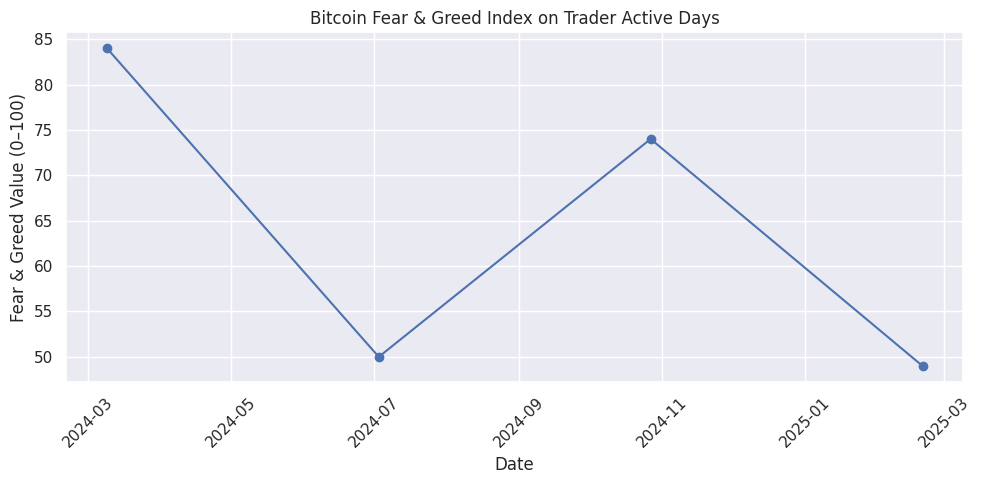

In [22]:
merged_valid = merged.dropna(subset=["fg_value"])

fig, ax1 = plt.subplots()
ax1.plot(merged_valid["date"], merged_valid["fg_value"], marker="o")
ax1.set_title("Bitcoin Fear & Greed Index on Trader Active Days")
ax1.set_xlabel("Date")
ax1.set_ylabel("Fear & Greed Value (0–100)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/sentiment_timeline.png", dpi=150)
plt.show()


## EDA – Volume vs Sentiment

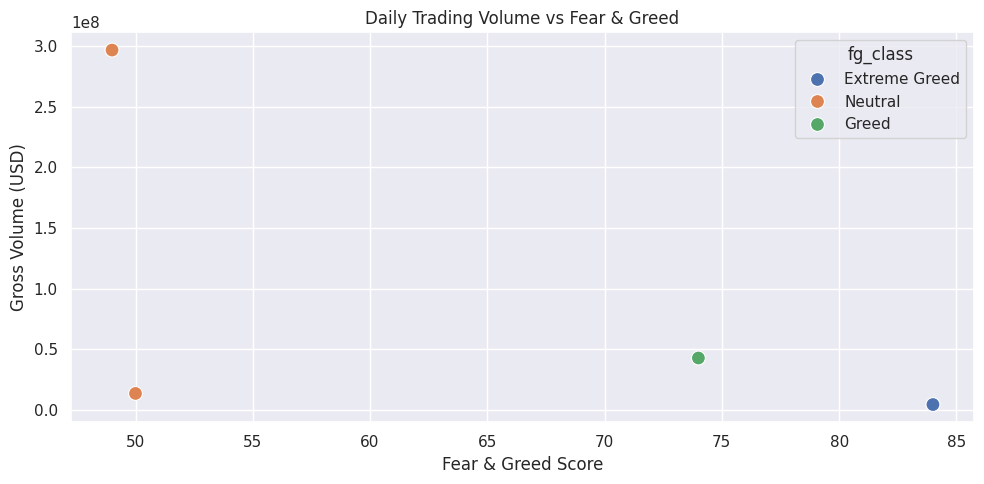

In [21]:
if not merged_valid.empty:
    sns.scatterplot(
        data=merged_valid,
        x="fg_value",
        y="gross_volume_usd",
        hue="fg_class",
        s=100
    )
    plt.title("Daily Trading Volume vs Fear & Greed")
    plt.xlabel("Fear & Greed Score")
    plt.ylabel("Gross Volume (USD)")
    plt.tight_layout()
    plt.savefig("outputs/volume_vs_sentiment.png", dpi=150)
    plt.show()
else:
    print("No merged_valid rows to plot.")


## EDA – Profitability vs Sentiment

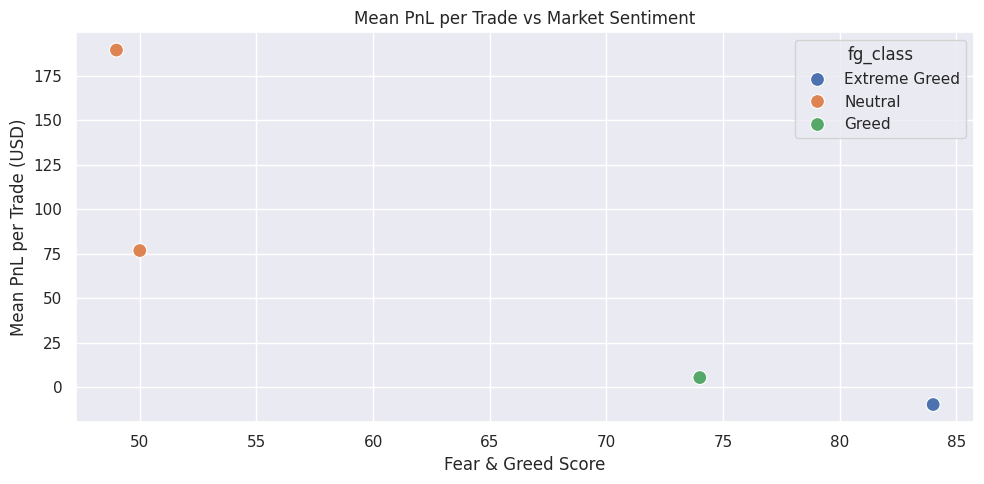

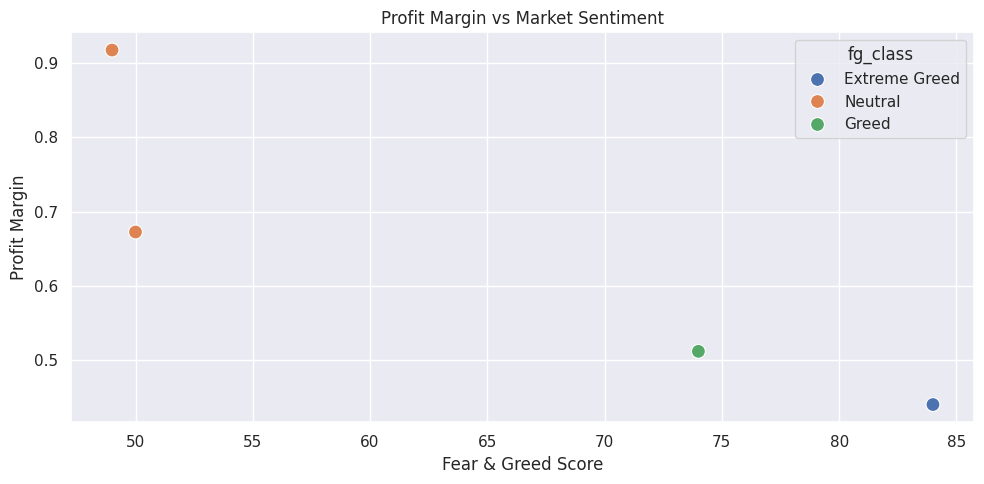

In [15]:
if not merged_valid.empty:
    sns.scatterplot(
        data=merged_valid,
        x="fg_value",
        y="mean_pnl_per_trade",
        hue="fg_class",
        s=100
    )
    plt.title("Mean PnL per Trade vs Market Sentiment")
    plt.xlabel("Fear & Greed Score")
    plt.ylabel("Mean PnL per Trade (USD)")
    plt.tight_layout()
    plt.savefig("outputs/pnl_vs_sentiment.png", dpi=150)
    plt.show()

    sns.scatterplot(
        data=merged_valid,
        x="fg_value",
        y="profit_margin",
        hue="fg_class",
        s=100
    )
    plt.title("Profit Margin vs Market Sentiment")
    plt.xlabel("Fear & Greed Score")
    plt.ylabel("Profit Margin")
    plt.tight_layout()
    plt.savefig("outputs/profit_margin_vs_sentiment.png", dpi=150)
    plt.show()
else:
    print("No merged_valid rows to plot.")


## EDA – Long vs Short Balance by Day

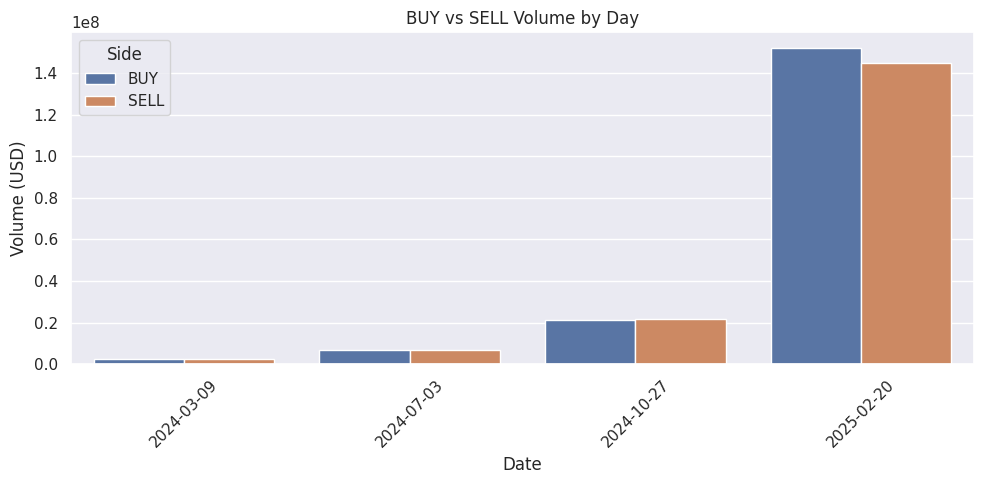

In [16]:
if "Side" in trades.columns and "Size USD" in trades.columns:
    side_daily = trades.groupby(["date", "Side"]).agg(
        volume_usd=("Size USD", "sum")
    ).reset_index()

    if hasattr(side_daily["date"], "dt"):
        side_daily["date"] = side_daily["date"].dt.tz_localize(None)
    if hasattr(fear["date"], "dt"):
        fear["date"] = fear["date"].dt.tz_localize(None)

    side_daily = side_daily.merge(
        fear[["date", "fg_class", "fg_value"]],
        on="date",
        how="left"
    )

    side_plot = side_daily.dropna(subset=["fg_class"])

    if not side_plot.empty:
        sns.barplot(
            data=side_plot,
            x="date",
            y="volume_usd",
            hue="Side"
        )
        plt.title("BUY vs SELL Volume by Day")
        plt.xlabel("Date")
        plt.ylabel("Volume (USD)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("outputs/long_short_balance.png", dpi=150)
        plt.show()
    else:
        print("No rows with sentiment to plot long/short balance.")
else:
    print("Missing Side or Size USD columns; cannot compute long/short balance.")



## Correlation of Sentiment with Trading Metrics

In [17]:
if "fg_value" in merged_valid.columns:
    corr = merged_valid.corr(numeric_only=True)["fg_value"].sort_values(ascending=False)
    print(corr)
else:
    print("fg_value not available for correlation.")


fg_value                 1.000000
median_trade_size_usd   -0.144319
accounts_n              -0.181256
total_loss              -0.278011
avg_trade_size_usd      -0.546448
gross_volume_usd        -0.575992
net_volume_usd          -0.580955
trades_count            -0.584994
total_profit            -0.608022
mean_pnl_per_trade      -0.863442
profit_margin           -0.889348
Name: fg_value, dtype: float64


In [18]:
merged.head(20)
merged.tail(20)
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   5 non-null      datetime64[ns]
 1   trades_count           5 non-null      int64         
 2   accounts_n             5 non-null      int64         
 3   gross_volume_usd       5 non-null      float64       
 4   net_volume_usd         5 non-null      float64       
 5   total_profit           5 non-null      float64       
 6   total_loss             5 non-null      float64       
 7   avg_trade_size_usd     5 non-null      float64       
 8   median_trade_size_usd  5 non-null      float64       
 9   mean_pnl_per_trade     5 non-null      float64       
 10  fg_value               4 non-null      float64       
 11  fg_class               4 non-null      object        
 12  profit_margin          5 non-null      float64       
dtypes: dateti

In [19]:
merged[merged["fg_class"].isna()]

,date,trades_count,accounts_n,gross_volume_usd,net_volume_usd,total_profit,total_loss,avg_trade_size_usd,median_trade_size_usd,mean_pnl_per_trade,fg_value,fg_class,profit_margin
4,2025-06-15,6740,5,2.577739e+08,-8635539.52,568385.393441,82975.871302,38245.38054,4182.47,72.019217,NaN,NaN,0.872612


In [20]:
daily.head(10)
daily.describe()

,date,trades_count,accounts_n,gross_volume_usd,net_volume_usd,total_profit,total_loss,avg_trade_size_usd,median_trade_size_usd,mean_pnl_per_trade
count,5,5.000000,5.00000,5.000000e+00,5.000000e+00,5.000000e+00,5.000000,5.000000,5.00000,5.000000
mean,2024-10-26 19:12:00,5586.200000,4.60000,1.231884e+08,-4.547321e+05,8.914898e+05,173550.036421,17105.767671,3232.86700,66.763636
min,2024-03-09 00:00:00,818.000000,2.00000,4.640448e+06,-8.635540e+06,2.942860e+04,37348.072899,5672.919829,1987.55000,-9.681505
25%,2024-07-03 00:00:00,1558.000000,2.00000,1.377735e+07,-4.993103e+05,2.330628e+05,82975.871302,8842.974705,1997.93000,5.446001
50%,2024-10-27 00:00:00,3094.000000,5.00000,4.297549e+07,-1.258049e+05,3.546388e+05,113490.900940,13889.945368,3995.67000,72.019217
75%,2025-02-20 00:00:00,6740.000000,7.00000,2.577739e+08,-2.707184e+04,5.683854e+05,296146.449793,18877.617913,4000.71500,76.747074
max,2025-06-15 00:00:00,15721.000000,7.00000,2.967750e+08,7.014066e+06,3.271934e+06,337788.887171,38245.380540,4182.47000,189.287392
std,NaN,6107.753531,2.50998,1.420423e+08,5.545305e+06,1.344972e+06,134504.678986,12838.885816,1134.58017,78.649655
